![ML Logo](http://spark-mooc.github.io/web-assets/images/CS190.1x_Banner_300.png)
# **Click-Through Rate Prediction**


In [1]:
# Load the Data and print a sample row
rawData = (sc.textFile('data/dac_sample.txt', 2)
            .map(lambda x: x.replace('\t', ',')))  # work with either ',' or '\t' separated data
print rawData.take(1)

[u'0,1,1,5,0,1382,4,15,2,181,1,2,,2,68fd1e64,80e26c9b,fb936136,7b4723c4,25c83c98,7e0ccccf,de7995b8,1f89b562,a73ee510,a8cd5504,b2cb9c98,37c9c164,2824a5f6,1adce6ef,8ba8b39a,891b62e7,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,,3a171ecb,c5c50484,e8b83407,9727dd16']


## Data format
* ####Label - Target variable that indicates if an ad was clicked (1) or not (0).
* ####I1-I13 - A total of 13 columns of integer features (mostly count features).
* ####C1-C26 - A total of 26 columns of categorical features. The values of these features have been hashed onto 32 bits for anonymization purposes. 

In [3]:
# Split the DataSet in train, validation and test sets
# TODO: Replace <FILL IN> with appropriate code
weights = [.8, .1, .1]
seed = 42
# Use randomSplit with weights and seed
rawTrainData, rawValidationData, rawTestData = rawData.randomSplit(weights,seed)
# Cache the data
rawTrainData.cache()
rawValidationData.cache()
rawTestData.cache()

nTrain = rawTrainData.count()
nVal = rawValidationData.count()
nTest = rawTestData.count()
print nTrain, nVal, nTest, nTrain + nVal + nTest
print rawData.take(1)

79911 10075 10014 100000
[u'0,1,1,5,0,1382,4,15,2,181,1,2,,2,68fd1e64,80e26c9b,fb936136,7b4723c4,25c83c98,7e0ccccf,de7995b8,1f89b562,a73ee510,a8cd5504,b2cb9c98,37c9c164,2824a5f6,1adce6ef,8ba8b39a,891b62e7,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,,3a171ecb,c5c50484,e8b83407,9727dd16']


In [6]:
# First Parse the points into a simple list of (featureID,value) tuples
# TODO: Replace <FILL IN> with appropriate code
def parsePoint(point):
    # Converts a comma separated string into a list of (featureID,value) tuples
    sp = point.split(',')
    z = [(i,sp[i+1]) for i in range(0,len(sp)-1)]
    return z

print parsePoint(u'0,1,1,5,0,1382,4,15,2,181,1,2,,2,68fd1e64,80e26c9b,fb936136,7b4723c4,25c83c98,7e0ccccf'+
                ',de7995b8,1f89b562,a73ee510,a8cd5504,b2cb9c98,37c9c164,2824a5f6,1adce6ef,8ba8b39a,891b62e7'+
                 ',e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,,3a171ecb,c5c50484,e8b83407,9727dd16')
parsedTrainFeat = rawTrainData.map(lambda x:parsePoint(x))

numCategories = (parsedTrainFeat
                 .flatMap(lambda x: x)
                 .distinct()
                 .map(lambda x: (x[0], 1))
                 .reduceByKey(lambda x, y: x + y)
                 .sortByKey()
                 .collect())

print numCategories[2][1]

[(0, u'1'), (1, u'1'), (2, u'5'), (3, u'0'), (4, u'1382'), (5, u'4'), (6, u'15'), (7, u'2'), (8, u'181'), (9, u'1'), (10, u'2'), (11, u''), (12, u'2'), (13, u'68fd1e64'), (14, u'80e26c9b'), (15, u'fb936136'), (16, u'7b4723c4'), (17, u'25c83c98'), (18, u'7e0ccccf'), (19, u'de7995b8'), (20, u'1f89b562'), (21, u'a73ee510'), (22, u'a8cd5504'), (23, u'b2cb9c98'), (24, u'37c9c164'), (25, u'2824a5f6'), (26, u'1adce6ef'), (27, u'8ba8b39a'), (28, u'891b62e7'), (29, u'e5ba7672'), (30, u'f54016b9'), (31, u'21ddcdc9'), (32, u'b1252a9d'), (33, u'07b5194c'), (34, u''), (35, u'3a171ecb'), (36, u'c5c50484'), (37, u'e8b83407'), (38, u'9727dd16')]
855


# One Hot Encoding

In [7]:
import numpy as np
from pyspark.mllib.linalg import SparseVector

def createOneHotDict(inputData):
    # This receives a RDD in the form (featureNum,str)
    # and returns a dictionary where each different tuple
    # is mapped to a unique integer
    s1 = (inputData.flatMap(lambda x:x).distinct())
    return s1.zipWithIndex().collectAsMap()

sampleOne = [(0, 'mouse'), (1, 'black')]
sampleTwo = [(0, 'cat'), (1, 'tabby'), (2, 'mouse')]
sampleThree =  [(0, 'bear'), (1, 'black'), (2, 'salmon')]
sampleDataRDD = sc.parallelize([sampleOne, sampleTwo, sampleThree])

sampleOHEDictAuto = createOneHotDict(sampleDataRDD)
print sampleOHEDictAuto

{(2, 'mouse'): 0, (0, 'cat'): 1, (0, 'bear'): 2, (2, 'salmon'): 3, (1, 'tabby'): 4, (1, 'black'): 5, (0, 'mouse'): 6}


In [8]:
# Create Dictionary from Dataset
zulu1=rawTrainData.map(lambda x:parsePoint(x))
#print zulu1.take(2)
ctrOHEDict = createOneHotDict(zulu1)

numCtrOHEFeats = len(ctrOHEDict.keys())
print numCtrOHEFeats
print ctrOHEDict[(0, '')]

233286
36177


In [12]:
# Encoding Function
def oneHotEncoding(rawFeats, OHEDict, numOHEFeats):
    # This takes a list of (featureId,value) and a OHE dictionary 
    # and returns a SparseVector of length numOHEFeats with indices
    # equal to the value for the dictionary for each (featureId,value) combination
    # Unseen features are ignored!
    feats = []
    for x in rawFeats:
        if x in OHEDict:
            code = OHEDict[x]
            feats.append(code)        
    nums = [1] * len(feats)
    return SparseVector(numOHEFeats,sorted(feats),nums)

In [13]:
# Convert each row to a LabeledPoin and a SparseVector of Features
# TODO: Replace <FILL IN> with appropriate code
from pyspark.mllib.regression import LabeledPoint

def parseOHEPoint(point, OHEDict, numOHEFeats):
    # point is a comma separated string, first is the label, rest are features
    # OHEDict is the OHE dictionary
    # Returns alabeled point
    sp = point.split(',')
    feats = [(i,sp[i+1]) for i in range(0,len(sp)-1)]
    label = sp[0]
    pp1 = oneHotEncoding(feats, OHEDict, numOHEFeats)
    return LabeledPoint(label,pp1)

OHETrainData = rawTrainData.map(lambda point: parseOHEPoint(point, ctrOHEDict, numCtrOHEFeats))
OHETrainData.cache()
print OHETrainData.take(1)

[LabeledPoint(0.0, (233286,[382,3101,6842,8311,8911,11887,12893,16211,17631,18646,23513,29366,33157,39536,55820,61797,81485,82753,93671,96986,109720,110662,112139,120263,128571,132400,132805,140595,160666,185457,190322,191105,195902,202638,204242,206037,222753,225966,229941],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]))]


In [14]:
# Apply to Validation DataSet
OHEValidationData = rawValidationData.map(lambda point: parseOHEPoint(point, ctrOHEDict, numCtrOHEFeats))
OHEValidationData.cache()
print OHEValidationData.take(1)

[LabeledPoint(0.0, (233286,[7623,9238,15597,21650,31238,36177,36577,39536,49203,61797,66635,67253,68245,68344,73075,76724,81421,81485,92068,96986,98511,109720,117014,121550,141683,146472,147618,171119,184096,184644,185457,185819,194734,198514,201019,210722,213593,222178,227716],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]))]


In [15]:
# Now Apply Logistic Regression
from pyspark.mllib.classification import LogisticRegressionWithSGD

# fixed hyperparameters
numIters = 50
stepSize = 10.
regParam = 1e-6
regType = 'l2'
includeIntercept = True

In [16]:
model0 = LogisticRegressionWithSGD.train(data=OHETrainData,iterations=numIters,step=stepSize,
                                         regParam=regParam,regType=regType,intercept=includeIntercept)
sortedWeights = sorted(model0.weights)
print sortedWeights[:5], model0.intercept

[-0.45899236853575615, -0.37973707648623961, -0.3699655826675331, -0.36934962879928279, -0.32697945415010637] 0.56455084025


#### ** (4b) Log loss **
#### Vamos a usar Log Loss como metrica para evaluar el algoritmo.  Log loss is defined as: $$  \begin{align} \scriptsize \ell_{log}(p, y) = \begin{cases} -\log (p) & \text{if } y = 1 \\\ -\log(1-p) & \text{if } y = 0 \end{cases} \end{align} $$ where $ \scriptsize p$ is a probability between 0 and 1 and $ \scriptsize y$ is a label of either 0 or 1. Log loss is a standard evaluation criterion when predicting rare-events such as click-through rate prediction (it is also the criterion used in the [Criteo Kaggle competition](https://www.kaggle.com/c/criteo-display-ad-challenge)). 

In [18]:
# LogLoss
from math import log

def computeLogLoss(p, y):
    # p is the probability
    # y is the label
    # Note log(0) is not defined! so we add epsilon to 0 or substract epsilon from 1
    epsilon = 10e-12
    if p==0:
        p=p+epsilon
    if p==1:
        p=p-epsilon
    if y==1:
        return -log(p)
    else:
        return -log(1-p)

print computeLogLoss(.5, 1)
print computeLogLoss(.5, 0)
print computeLogLoss(.99, 1)
print computeLogLoss(.99, 0)
print computeLogLoss(.01, 1)
print computeLogLoss(.01, 0)
print computeLogLoss(0, 1)
print computeLogLoss(1, 1)
print computeLogLoss(1, 0)

0.69314718056
0.69314718056
0.0100503358535
4.60517018599
4.60517018599
0.0100503358535
25.3284360229
1.00000008275e-11
25.3284359402


In [19]:
# Baseline, using just the average of clicks (average labels)
classOneFracTrain = OHETrainData.map(lambda x:x.label).mean()
print classOneFracTrain

logLossTrBase = OHETrainData.map(lambda x:computeLogLoss(classOneFracTrain,x.label)).mean()
print 'Baseline Train Logloss = {0:.3f}\n'.format(logLossTrBase)

0.22717773523
Baseline Train Logloss = 0.536



In [20]:
# Compute Predictions from Logistic Regression Coefficients
from math import exp #  exp(-t) = e^-t

def getP(x, w, intercept):
    # x is a point
    # w is the vector of coefficients
    # intercept is you know what
    # returns a probability sigmoid(w*x+intercept)
    rawPrediction = x.dot(w) + intercept   
    # Bound the raw prediction value
    rawPrediction = min(rawPrediction, 20)
    rawPrediction = max(rawPrediction, -20)
    return 1/(1+exp(-rawPrediction))

trainingPredictions = OHETrainData.map(lambda x:getP(x.features,model0.weights,model0.intercept))
print trainingPredictions.take(5)

[0.3026288202391113, 0.10362661997434078, 0.283634247838756, 0.1784610205788012, 0.5389775379218853]


In [21]:
# A Function to evaluate Results
def evaluateResults(model, data):
    return data.map(lambda x:computeLogLoss(getP(x.features,model.weights,model.intercept),x.label)).sum() / data.count()

logLossTrLR0 = evaluateResults(model0, OHETrainData)
print ('OHE Features Train Logloss:\n\tBaseline = {0:.3f}\n\tLogReg = {1:.3f}'
       .format(logLossTrBase, logLossTrLR0))

OHE Features Train Logloss:
	Baseline = 0.536
	LogReg = 0.457


In [22]:
# Validation Log Loss
logLossValBase = OHEValidationData.map(lambda x:computeLogLoss(classOneFracTrain,x.label)).mean()

logLossValLR0 = evaluateResults(model0, OHEValidationData)
print ('OHE Features Validation Logloss:\n\tBaseline = {0:.3f}\n\tLogReg = {1:.3f}'
       .format(logLossValBase, logLossValLR0))

OHE Features Validation Logloss:
	Baseline = 0.528
	LogReg = 0.457


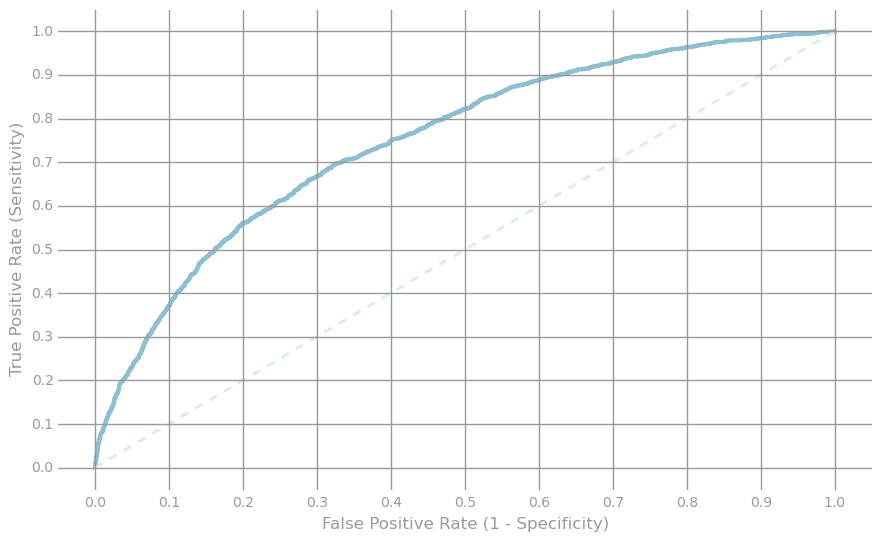

In [26]:
# Now print ROC curve
import matplotlib.pyplot as plt

labelsAndScores = OHEValidationData.map(lambda lp:
                                            (lp.label, getP(lp.features, model0.weights, model0.intercept)))
labelsAndWeights = labelsAndScores.collect()
labelsAndWeights.sort(key=lambda (k, v): v, reverse=True)
labelsByWeight = np.array([k for (k, v) in labelsAndWeights])

length = labelsByWeight.size
truePositives = labelsByWeight.cumsum()
numPositive = truePositives[-1]
falsePositives = np.arange(1.0, length + 1, 1.) - truePositives

truePositiveRate = truePositives / numPositive
falsePositiveRate = falsePositives / (length - numPositive)

def preparePlot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999',
                gridWidth=1.0):
    """Template for generating the plot layout."""
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hideLabels: axis.set_ticklabels([])
    plt.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax


# Generate layout and plot data
fig, ax = preparePlot(np.arange(0., 1.1, 0.1), np.arange(0., 1.1, 0.1))
ax.set_xlim(-.05, 1.05), ax.set_ylim(-.05, 1.05)
ax.set_ylabel('True Positive Rate (Sensitivity)')
ax.set_xlabel('False Positive Rate (1 - Specificity)')
plt.plot(falsePositiveRate, truePositiveRate, color='#8cbfd0', linestyle='-', linewidth=3.)
plt.plot((0., 1.), (0., 1.), linestyle='--', color='#d6ebf2', linewidth=2.)  # Baseline model
pass

# Feature Hashing

In [31]:
from collections import defaultdict
import hashlib

def hashFunction(numBuckets, rawFeats, printMapping=False):
    # numBuckets is the number of buckets to use as features
    # rawFeats is a list of tuples in the form (featureId,value)
    # returns a dictionary of int to float, the keys are the buckets that
    # features have been hashed to. The value is the count of tuples hashed to that key
    mapping = {}
    for ind, category in rawFeats:
        featureString = category + str(ind)
        #mapping[featureString] = int(int(hashlib.md5(featureString).hexdigest(), 16) % numBuckets)
        mapping[featureString] = hash(featureString) % numBuckets
    if(printMapping): print mapping
    sparseFeatures = defaultdict(float)
    for bucket in mapping.values():
        sparseFeatures[bucket] += 1.0
    return dict(sparseFeatures)

In [32]:
sampOneFourBuckets = hashFunction(4, sampleOne, True)
sampTwoFourBuckets = hashFunction(4, sampleTwo, True)
sampThreeFourBuckets = hashFunction(4, sampleThree, True)

# Use one hundred buckets
sampOneHundredBuckets = hashFunction(100, sampleOne, True)
sampTwoHundredBuckets = hashFunction(100, sampleTwo, True)
sampThreeHundredBuckets = hashFunction(100, sampleThree, True)

print '\t\t 4 Buckets \t\t\t 100 Buckets'
print 'SampleOne:\t {0}\t\t {1}'.format(sampOneFourBuckets, sampOneHundredBuckets)
print 'SampleTwo:\t {0}\t\t {1}'.format(sampTwoFourBuckets, sampTwoHundredBuckets)
print 'SampleThree:\t {0}\t {1}'.format(sampThreeFourBuckets, sampThreeHundredBuckets)

{'black1': 0, 'mouse0': 1}
{'cat0': 0, 'tabby1': 1, 'mouse2': 3}
{'bear0': 3, 'black1': 0, 'salmon2': 3}
{'black1': 28, 'mouse0': 1}
{'cat0': 0, 'tabby1': 53, 'mouse2': 3}
{'bear0': 87, 'black1': 28, 'salmon2': 39}
		 4 Buckets 			 100 Buckets
SampleOne:	 {0: 1.0, 1: 1.0}		 {1: 1.0, 28: 1.0}
SampleTwo:	 {0: 1.0, 1: 1.0, 3: 1.0}		 {0: 1.0, 3: 1.0, 53: 1.0}
SampleThree:	 {0: 1.0, 3: 2.0}	 {87: 1.0, 28: 1.0, 39: 1.0}


In [33]:
# Now use that to create the hashed features
def parseHashPoint(point, numBuckets):
    # Create a labeledpoint from the string with commas using hashing
    sp = point.split(',')
    feats = [(i,sp[i+1]) for i in range(0,len(sp)-1)]
    label = sp[0]
    print feats
    pp1 = hashFunction(numBuckets,feats)
    fs = pp1.keys()
    vl = pp1.values()
    fs,vl = zip(*sorted(zip(fs, vl)))
    return LabeledPoint(label,SparseVector(numBuckets,fs,vl))
    

numBucketsCTR = 2 ** 15
hashTrainData = rawTrainData.map(lambda x:parseHashPoint(x,numBucketsCTR))
hashTrainData.cache()
hashValidationData = rawValidationData.map(lambda x:parseHashPoint(x,numBucketsCTR))
hashValidationData.cache()
hashTestData = rawTestData.map(lambda x:parseHashPoint(x,numBucketsCTR))
hashTestData.cache()

print hashTrainData.take(1)

[LabeledPoint(0.0, (32768,[39,259,636,991,1176,1927,3340,3588,3590,6634,8726,9644,10657,13903,14214,14503,15319,16520,17545,17569,18309,19296,19297,19304,20835,21027,21965,22587,22767,23196,24491,24596,25285,25432,26223,29493,32115,32735],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]))]


In [34]:
# Check sparsity
def computeSparsity(data, d, n):
    # data is a RDD of LabeledPoints
    # d is the total number of features
    # n is the total number of observations
    return data.map(lambda x:float(len(x.features.indices))/d).mean()

#print hashTrainData.map(lambda x:float(len(x.features.indices))/10).mean()

averageSparsityHash = computeSparsity(hashTrainData, numBucketsCTR, nTrain)
averageSparsityOHE = computeSparsity(OHETrainData, numCtrOHEFeats, nTrain)

print 'Average OHE Sparsity: {0:.7e}'.format(averageSparsityOHE)
print 'Average Hash Sparsity: {0:.7e}'.format(averageSparsityHash)

Average OHE Sparsity: 1.6717677e-04
Average Hash Sparsity: 1.1819767e-03


In [35]:
# Now Apply Logistic Regression
numIters = 500
regType = 'l2'
includeIntercept = True

# Initialize variables using values from initial model training
bestModel = None
bestLogLoss = 1e10

In [36]:
# Grid Search
stepSizes = [1,10]
regParams = [1e-6,1e-3]
for stepSize in stepSizes:
    for regParam in regParams:
        model = (LogisticRegressionWithSGD
                 .train(hashTrainData, numIters, stepSize, regParam=regParam, regType=regType,
                        intercept=includeIntercept))
        logLossVa = evaluateResults(model, hashValidationData)
        print ('\tstepSize = {0:.1f}, regParam = {1:.0e}: logloss = {2:.3f}'
               .format(stepSize, regParam, logLossVa))
        if (logLossVa < bestLogLoss):
            bestModel = model
            bestLogLoss = logLossVa

print ('Hashed Features Validation Logloss:\n\tBaseline = {0:.3f}\n\tLogReg = {1:.3f}'
       .format(logLossValBase, bestLogLoss))

	stepSize = 1.0, regParam = 1e-06: logloss = 0.470
	stepSize = 1.0, regParam = 1e-03: logloss = 0.470
	stepSize = 10.0, regParam = 1e-06: logloss = 0.448
	stepSize = 10.0, regParam = 1e-03: logloss = 0.450
Hashed Features Validation Logloss:
	Baseline = 0.528
	LogReg = 0.448


In [38]:
# Finally Evaluate Best Model on Test Set
logLossTest = evaluateResults(bestModel, hashTestData)

# Log loss for the baseline model
logLossTestBaseline =  hashTestData.map(lambda x:computeLogLoss(classOneFracTrain,x.label)).mean()

print ('Hashed Features Test Log Loss:\n\tBaseline = {0:.3f}\n\tLogReg = {1:.3f}'
       .format(logLossTestBaseline, logLossTest))

Hashed Features Test Log Loss:
	Baseline = 0.537
	LogReg = 0.456


In [43]:
# Print our predictions
def getPredictions(model, data):
    return data.map(lambda x:(getP(x.features,model.weights,model.intercept),x.label))
preds = getPredictions(bestModel, hashTestData).collect()

print 'Real Value'+'\t'+'Prediction Prob'
for p in preds:
    print str(p[1])+'\t'+str(p[0])

Real Value	Prediction Prob
0.0	0.0952389932974
0.0	0.0649037083342
0.0	0.190401233388
0.0	0.0821605579388
0.0	0.10895243055
0.0	0.310788658395
0.0	0.195188026443
1.0	0.532513030439
0.0	0.350963419887
0.0	0.262564265432
0.0	0.319840498291
1.0	0.28814131192
0.0	0.338287801324
1.0	0.132603312279
0.0	0.260540968378
0.0	0.468239261025
0.0	0.0875683450368
0.0	0.0808560676219
1.0	0.713793921427
0.0	0.0484978312249
0.0	0.304781139498
0.0	0.0348611734765
0.0	0.220889502592
0.0	0.271390220688
0.0	0.305498532972
0.0	0.0839587891274
1.0	0.22699904898
0.0	0.0980598878568
0.0	0.301980711845
1.0	0.47936912408
0.0	0.179926415677
1.0	0.239686440461
0.0	0.0589397833799
0.0	0.0478609365676
0.0	0.0591866802494
0.0	0.102612885843
1.0	0.153727188568
1.0	0.309115936059
1.0	0.0685565243104
0.0	0.423511531422
1.0	0.171477568149
0.0	0.25671906065
0.0	0.121081689652
0.0	0.111268220849
0.0	0.144422099983
0.0	0.0548064412825
0.0	0.12991543529
0.0	0.259868083365
0.0	0.0933067178467
0.0	0.0560234913522
0.0	0.0404305